# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements
Python 3.6 Tensorflow 1.15

Download the desired log, vehicle model, and complete model tar files from the DeepRacer console

1. Go to (https://console.aws.amazon.com/deepracer/home?region=us-east-1#)

2. Navigate to your trained model. Under actions, select "Download Physical Car Model"

<img src="./images/download1new.png" width=550>

3. Download training and/or evaluation resource log file. Below is screenshot of evaluation logs.

<img src="./images/download2.png" width=550>

4. Place all files under the <code> aws-deepracer-workshops/log_analysis/assets </code> folder and continue.

In [1]:
# AW: optional, comment out if not using autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import shutil
import os
import glob
import math
import tarfile
import requests
import json
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
import glob
%matplotlib inline

In [3]:
!pip install shapely

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [4]:
from log_analysis import *
from os import listdir
from os.path import isfile, join

In [5]:
model_name="ASK2-OvalTrack-Suman-06-04-clone" ## Change to your model i.e. model-1
is_training = True  ## Make this False if you want to do log analysis on Evaluation.

simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(model_name)
if not is_training:
    simtrace_path = "./downloaded_model/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(model_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

In [6]:
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model

In [7]:
envroot = os.getcwd()
aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

In [8]:
# Set model_logs_file to the name of the training and/or evaluation *_logs.tar.gz file 
if is_training:
    model_logs_file = "ASK2-OvalTrack-Suman-06-04-clone-training_job_WO6MDq7aSYOAK7PDKQ6q5Q_logs.tar.gz"
else:
    model_logs_file = "model-1-evaluation_job_F4P-IybLSEeW_5O24PO2BQ_logs.tar.gz"

!mkdir -p downloaded_model/{model_name}
!mkdir -p intermediate_checkpoint/{model_name}/model-artifacts

!tar -xf ./assets/{model_logs_file} -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include=*.csv --exclude=* {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}

In [9]:
# AW: had to update to specific model path
# Logs to local computer 
# *_all_logs.tar.gz
# !tar zxvf ./assets/{model_name}-model_all_logs.tar.gz -C intermediate_checkpoint/ \*.csv {model_name}/* 
!tar zxvf ./assets/ASK2-OvalTrack-Suman-06-04-clone-training_job_WO6MDq7aSYOAK7PDKQ6q5Q_logs.tar.gz -C intermediate_checkpoint/ \*.csv {model_name}/* 

x ASK2-OvalTrack-Suman-06-04-clone/logs/training/training-20210714193717-WO6MDq7aSYOAK7PDKQ6q5Q-sagemaker.log
x ASK2-OvalTrack-Suman-06-04-clone/logs/training/training-20210714193718-WO6MDq7aSYOAK7PDKQ6q5Q-robomaker.log
x ASK2-OvalTrack-Suman-06-04-clone/metrics/training/training-20210714185156-WO6MDq7aSYOAK7PDKQ6q5Q.json
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/0-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/1-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/2-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/3-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/4-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/5-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/training-simtrace/6-iteration.csv
x ASK2-OvalTrack-Suman-06-04-clone/sim-trace/training/traini

In [10]:
# Model for physical car racing to local computer
# *-model.tar.gz
!tar zxvf ./assets/{model_name}-model.tar.gz -C intermediate_checkpoint/{model_name}/model-artifacts

x model_metadata.json
x agent/
x agent/model.pb
x worker_0.multi_agent_graph_0.json
x worker_0.multi_agent_graph.main_level.main_level.agent_0.csv


In [11]:
with open("intermediate_checkpoint/{}/model-artifacts/model_metadata.json".format(model_name),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': {'steering_angle': {'high': 25, 'low': -25},
  'speed': {'high': 3.5, 'low': 0.5}},
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '4',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'continuous'}

## Job run from Public Notebook. Download the desired log file given the simulation ID 

#### Merge all the csv files into one big .csv file

In [12]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                print(csv_file)
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line.replace('[', '"').replace(']', '"'))

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

./tmp/0-iteration.csv
./tmp/1-iteration.csv
./tmp/2-iteration.csv
./tmp/3-iteration.csv
./tmp/4-iteration.csv
./tmp/5-iteration.csv
./tmp/6-iteration.csv
./tmp/7-iteration.csv
./tmp/8-iteration.csv
./tmp/9-iteration.csv
199,40.0,5.059206917518247,0.5613696120128874,-32.58232847866394,19.778880122585477,3.2163055210878806,"19.778880122585477, 3.2163055210878806",0.001,False,False,15.670724921813346,11,19.549800178858835,932.119,in_progress,0.0
199,41.0,5.170382360099382,0.4965042767590154,-31.44327083746522,25.0,1.7926795707189673,"25.0, 1.7926795707189673",0.001,False,False,16.239008421490496,11,19.549800178858835,932.189,in_progress,0.0
199,42.0,5.285369877769943,0.4406540759017419,-28.906777528109135,16.3466947200858,2.7045289990881716,"16.3466947200858, 2.7045289990881716",0.001,True,False,16.827153767225127,12,19.549800178858835,932.26,off_track,0.0


## Load waypoints for the track you want to run analysis on


In [13]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['reInvent2019_track.npy', 'Canada_Training.npy', 'reInvent2019_wide.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'reInvent2019_wide_mirrored.npy', 'AmericasGeneratedInclStart.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Belille.npy', 'H_track.npy', 'reinvent_base.npy', 'Mexico_track.npy', 'Spain_track.npy', 'Vegas_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'Albert.npy', 'China_track.npy', 'LGSWide.npy', 'July_2020.npy', 'FS_June2020.npy', 'London_Loop_Train.npy', 'ChampionshipCup2019_track.npy']


In [14]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

# Set track variable from above list, exclude the .npy extension
track = 'Oval_track'

waypoints = get_track_waypoints(track) ### re:invent track
waypoints.shape

(102, 6)

## Visualize the Track and Waypoints

In [15]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

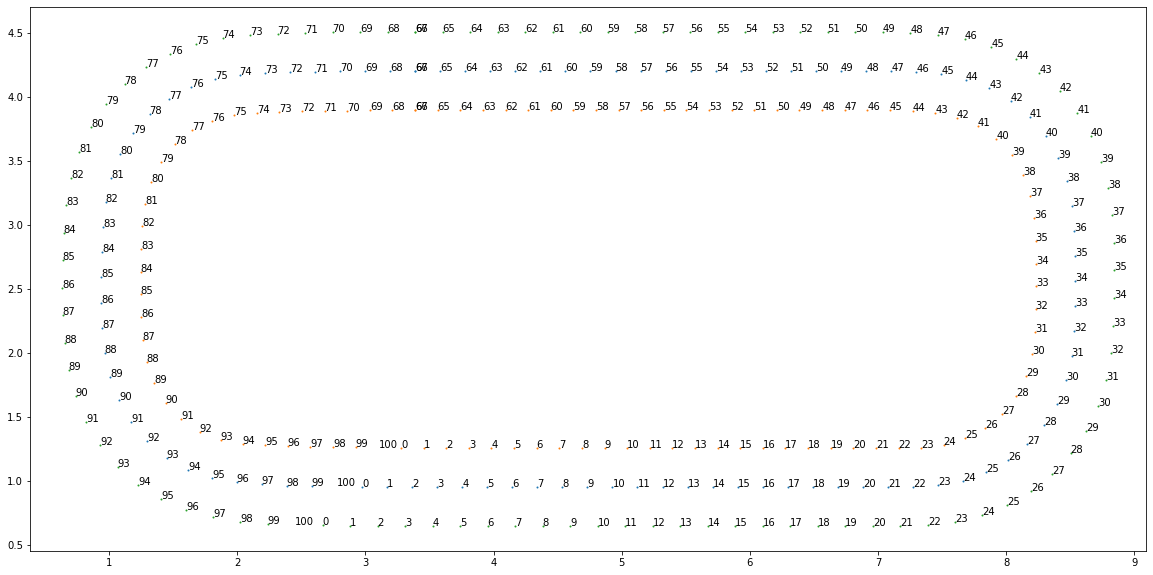

In [16]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

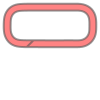

In [17]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [18]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [19]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
        #plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [45]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            print(x1,y1,action,reward,angle,speed)
            if idx == 20:
                sys.exit()
            car_x2, car_y2 = float(x1) - 0.02, float(y1)
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [21]:
EPISODE_PER_ITER = 20 if is_training else 1

In [22]:
df = pd.read_csv(merged_simtrace_path, index_col=False)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.tail()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
8658,199,38.0,4.877183,0.678805,-31.664505,-20.332106,3.480984,"-20.33210554396773, 3.480984033888916",0.001,False,False,14.739781,10,19.5498,931.987,in_progress,0.0,10
8659,199,39.0,4.970478,0.619046,-32.168904,25.000000,1.283105,"25.0, 1.2831052666001537",0.001,False,False,15.216844,10,19.5498,932.033,in_progress,0.0,10
8660,199,40.0,5.059207,0.561370,-32.582328,19.778880,3.216306,"19.778880122585477, 3.2163055210878806",0.001,False,False,15.670725,11,19.5498,932.119,in_progress,0.0,10
8661,199,41.0,5.170382,0.496504,-31.443271,25.000000,1.792680,"25.0, 1.7926795707189673",0.001,False,False,16.239008,11,19.5498,932.189,in_progress,0.0,10
8662,199,42.0,5.285370,0.440654,-28.906778,16.346695,2.704529,"16.3466947200858, 2.7045289990881716",0.001,True,False,16.827154,12,19.5498,932.260,off_track,0.0,10


In [23]:
df['x'].min(), df['x'].max()

(0.3780102397678831, 9.138205606495797)

In [24]:
df[df.episode == 152.0]

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
6262,152,1.0,4.420651,4.199795,179.976550,25.000000,0.856781,"25.0, 0.8567812552463574",0.000,False,True,0.716555,61,19.5498,731.190,prepare,0.0,8
6263,152,2.0,4.420736,4.199707,-179.979098,25.000000,1.844338,"25.0, 1.8443380836713128",67499.251,False,True,0.716120,61,19.5498,731.207,in_progress,0.0,8
6264,152,3.0,4.414682,4.200802,179.696236,25.000000,3.453458,"25.0, 3.453458099137004",40499.551,False,True,0.747083,61,19.5498,731.323,in_progress,0.0,8
6265,152,4.0,4.396563,4.201414,179.530122,-11.424688,0.806889,"-11.42468750734618, 0.8068894454529135",53999.401,False,True,0.839766,61,19.5498,731.389,in_progress,0.0,8
6266,152,5.0,4.362252,4.200323,179.478887,-9.733253,0.500000,"-9.733252747386661, 0.5",53999.401,False,True,1.015272,61,19.5498,731.455,in_progress,0.0,8
6267,152,6.0,4.322487,4.197482,-179.716189,19.291102,3.088599,"19.29110200562689, 3.088598724509865",67499.251,False,True,1.218683,61,19.5498,731.524,in_progress,0.0,8
6268,152,7.0,4.276295,4.195552,-179.304770,-12.995390,3.500000,"-12.995390176847554, 3.5",80999.101,False,True,1.454967,61,19.5498,731.583,in_progress,0.0,8
6269,152,8.0,4.213915,4.190053,-178.230158,-25.000000,3.500000,"-25.0, 3.5",67499.251,False,True,1.774062,62,19.5498,731.655,in_progress,0.0,8
6270,152,9.0,4.132500,4.187010,-178.157503,-25.000000,0.500000,"-25.0, 0.5",67499.251,False,True,2.190531,62,19.5498,731.712,in_progress,0.0,8
6271,152,10.0,4.057223,4.193126,179.559872,-9.774482,3.487024,"-9.774482115787448, 3.4870244378101387",53999.401,False,True,2.575561,63,19.5498,731.793,in_progress,0.0,8


In [25]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [26]:
scaled_vals

array([[0.00000000e+00],
       [6.00000003e-01],
       [5.00000004e-01],
       ...,
       [7.40748966e-09],
       [7.40748966e-09],
       [7.40748966e-09]])

In [27]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  199


Text(0.5, 0, 'Episode')

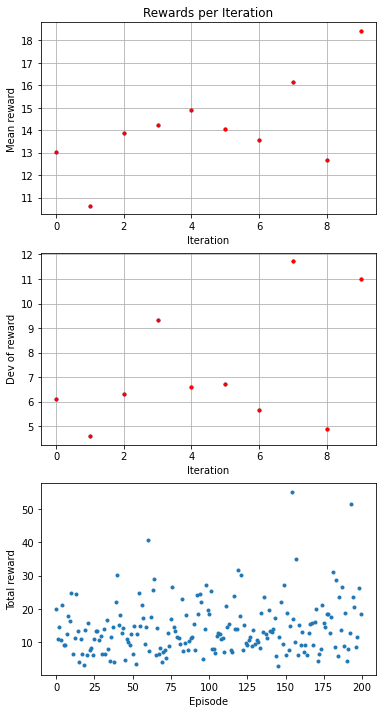

In [28]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = int(np.min(df['episode']))
max_episodes = int(np.max(df['episode']))
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes+1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [29]:
if is_training:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/training/*.json".format(model_name))[0]
else:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/evaluation/*.json".format(model_name))[0]
    
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [30]:
df_metrics

,completion_percentage,elapsed_time_in_milliseconds,episode,episode_status,metric_time,phase,reward_score,start_time,trial
0,21,3058,1,Off track,21120,training,2686470,18062,1
1,18,2546,2,Off track,23727,training,1471484,21181,2
2,16,2729,3,Off track,26515,training,1970978,23786,3
3,12,1804,4,Off track,28384,training,1444484,26580,4
4,32,4003,5,Off track,32457,training,2861968,28454,5
5,18,2654,6,Off track,35168,training,1228486,32514,6
6,12,2070,7,Off track,37320,training,1228486,35250,7
7,14,2134,8,Off track,39521,training,1700981,37387,8
8,23,3534,9,Off track,43121,training,2429973,39587,9
9,21,3008,10,Off track,46189,training,2213975,43181,10


Mean percentage: 19.195


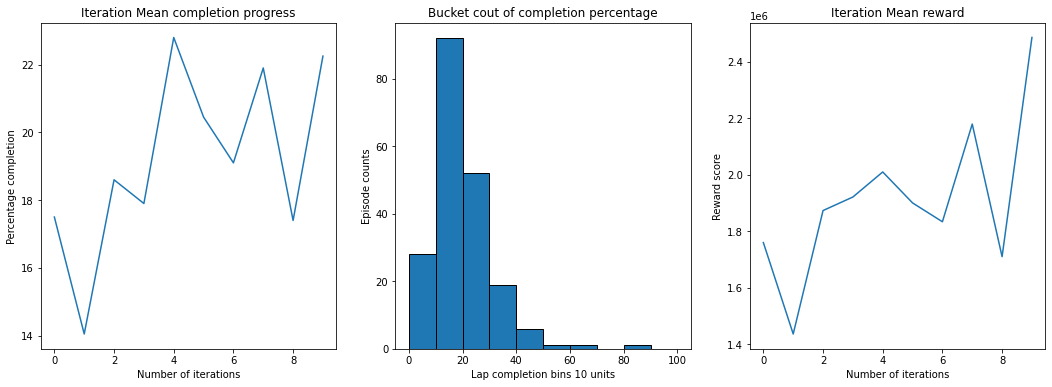

In [31]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze the reward distribution for your reward function

In [32]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis 0.3780102397678831; Max x-axis 9.138205606495797
Min y-axis 0.3275793507034833; Max y-axis 4.839907421682914


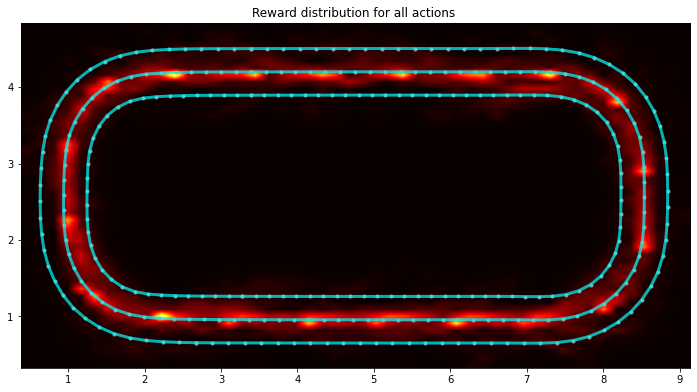

In [33]:
track,extent = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


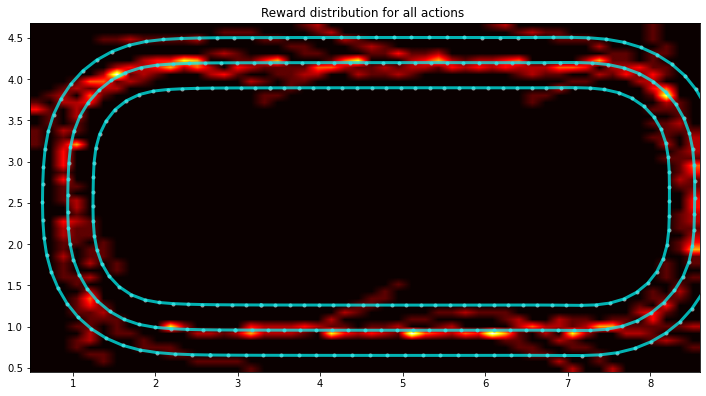

In [34]:
iteration_id = 1
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

In [51]:
# AW: something is messed up here, skipping plot for now. You can plug it into the next graph instead
action_map, episode_map, sorted_idx = episode_parser(df)    
#fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

The top 3 highest reward episodes are [154, 193, 60]


### Path taken in a particular episode

In [49]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

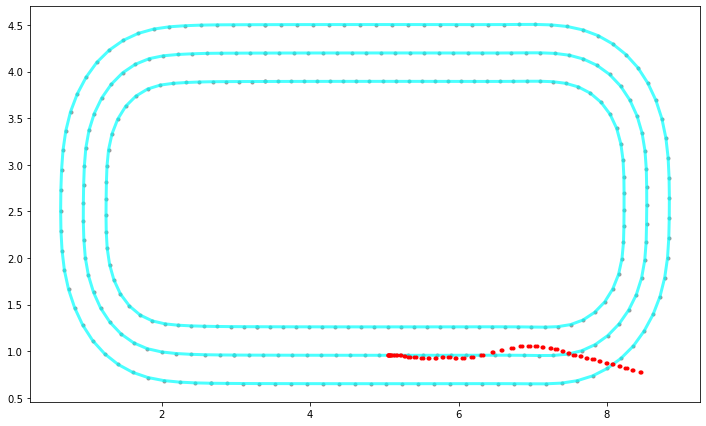

In [53]:
plot_episode_run(df, E=2) # arbitrary episode

### Path taken in a particular Iteration

/Users/ashton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


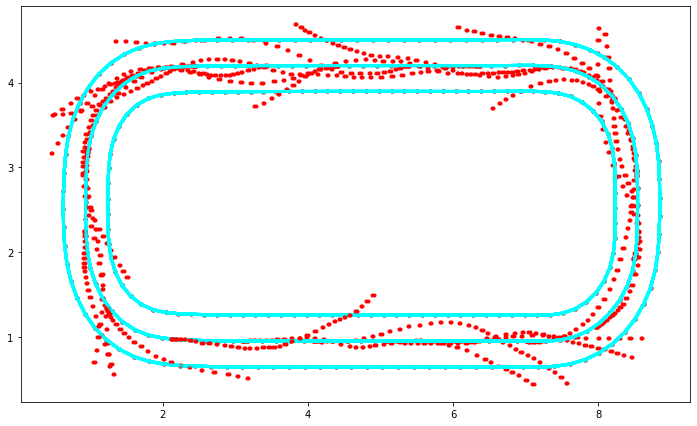

In [54]:
iteration_id = 1

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [55]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [58]:
# Track Segment Labels
# AW: I think this is not going to work with the continuous action space. Maybe you could split it out into
# categories but it would be complicated. Skipping this for now.
action_names = []
print(model_metadata['action_space'])
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

{'steering_angle': {'high': 25, 'low': -25}, 'speed': {'high': 3.5, 'low': 0.5}}


TypeError: string indices must be integers

Number of steps in iteration= 349


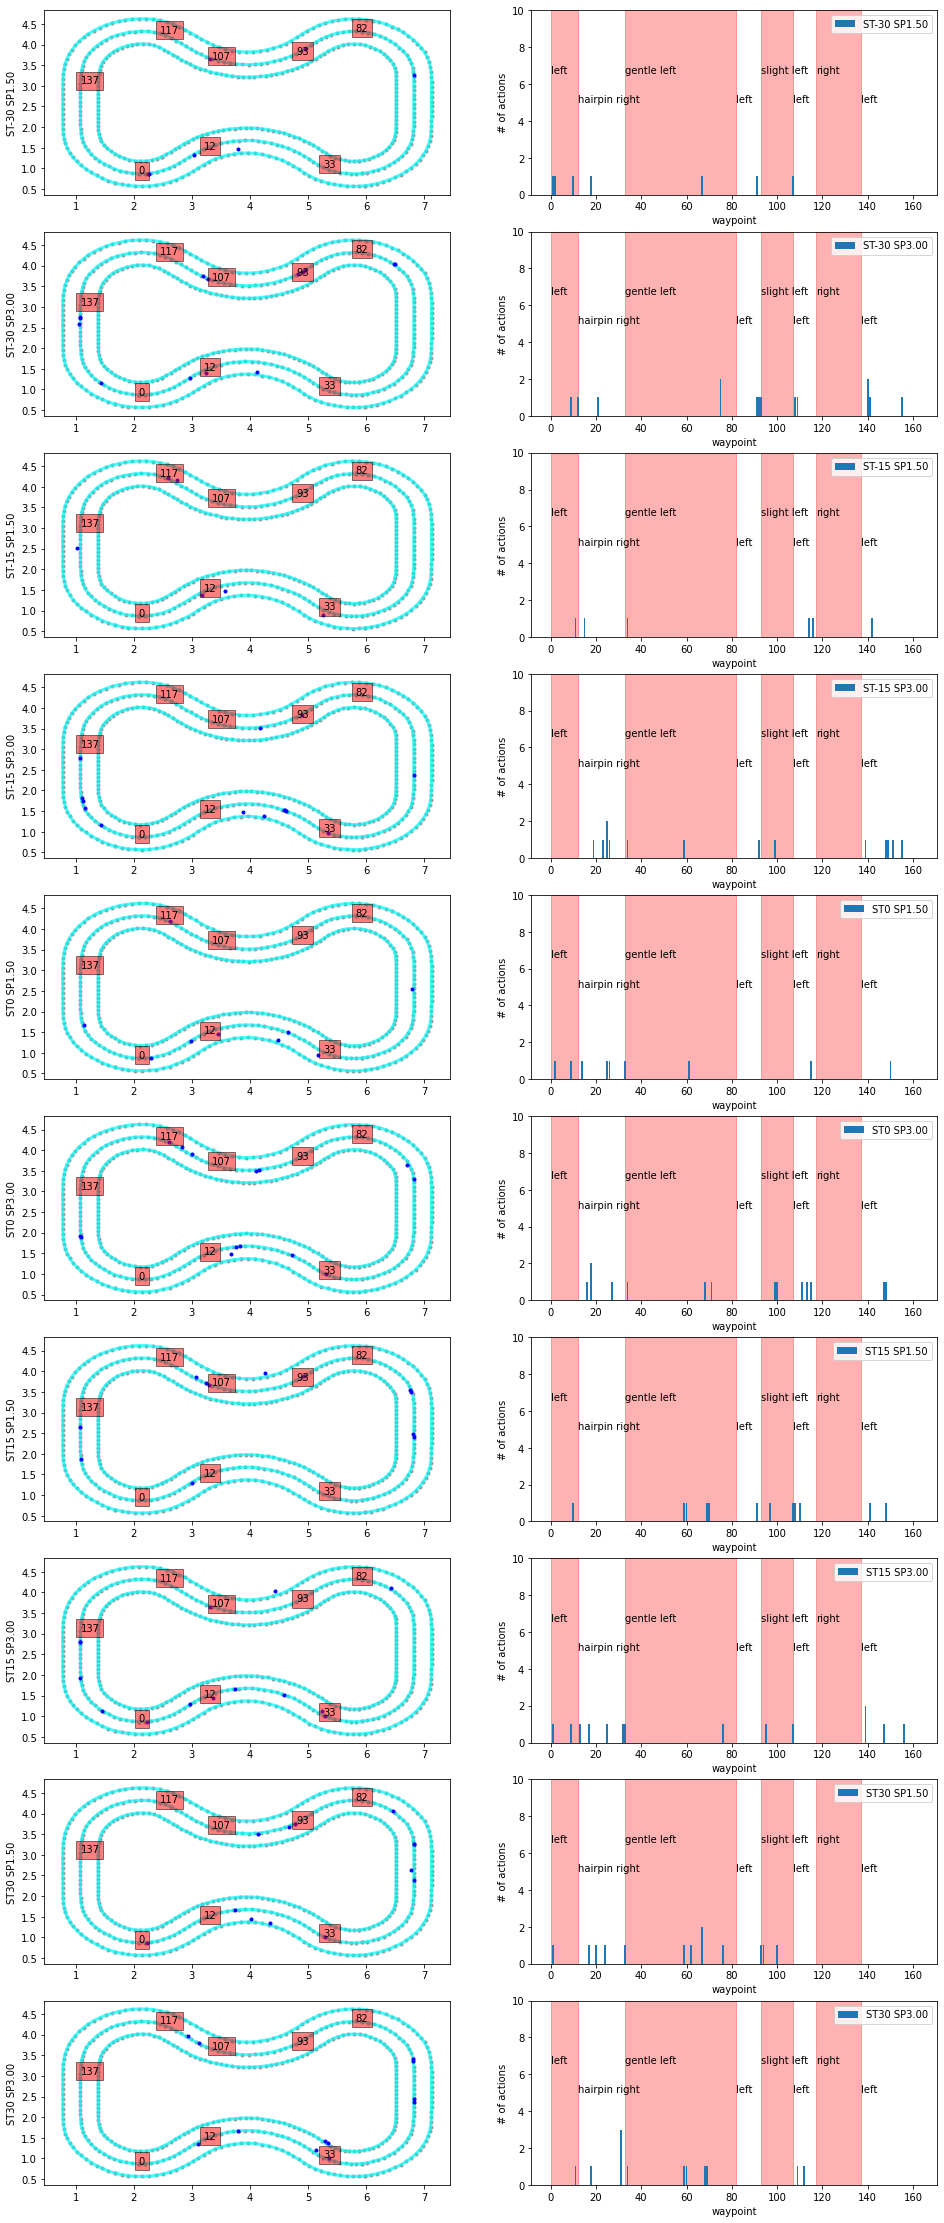

In [38]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

#action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [0,12,33,82,93,107,117,137]
y_limit = 10
track_segments = [(0, .66*y_limit, 'left'),
                  (12, .5*y_limit, 'hairpin right'),
                  (33, .66*y_limit, 'gentle left'),
                  (82, .5*y_limit, 'left'),
                  (93, .66*y_limit, 'slight left'),
                  (107, .5*y_limit, 'left'),
                  (117, .66*y_limit, 'right'),
                  (137, .5*y_limit, 'left')
                 ]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(vert_lines):
    segment_x.append(vert_lines[i])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>len(vert_lines)-1:
        segment_xerr_r.append(len(waypoints)-vert_lines[i])
    else:
        segment_xerr_r.append(vert_lines[i+1]-vert_lines[i])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1], str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [61]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

[autoreload of six failed: Traceback (most recent call last):
  File "/Users/ashton/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ashton/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/ashton/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/Users/ashton/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 274, in update_class
    old_obj = getattr(old, key)
  File "/Users/ashton/miniconda3/lib/python3.7/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of pkg_resources.extern.appdirs failed: Traceback (most recent call last):
  File "/Users/ashton/minic

#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [62]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [63]:
model_inference = []
iterations = [7,8,9]
models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, model_name))

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.compat.v1.reset_default_graph()

In [64]:
prob_diff = []

for model, model_file in zip(model_inference, models_file_path):
    print("Inference for model: {}".format(model_file))
    for mi in model:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

The model which appears to have a better seperation in probabability will work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [65]:
fname = './intermediate_checkpoint/{}/model-artifacts/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'.format(model_name)
df_csv = pd.read_csv(fname)

In [66]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

<AxesSubplot:title={'center':'Training'}, xlabel='Training Iter'>

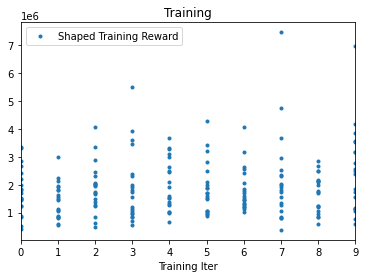

In [67]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

<AxesSubplot:>

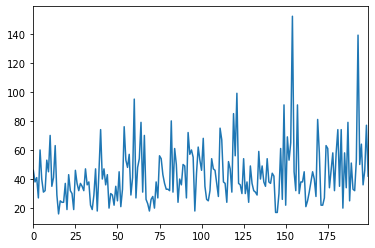

In [68]:
df_csv['Episode Length'].plot()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [70]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [71]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [73]:
#model_path = models_file_path[0] #Change this to your model 'pb' frozen graph file
# AW: hardcode this
# AW: couldn't get it working unfortunately
model_path = "intermediate_checkpoint/ASK2-OvalTrack-Suman-06-04-clone/model-artifacts/agent/model.pb"

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping: no known devices.
load graph: intermediate_checkpoint/ASK2-OvalTrack-Suman-06-04-clone/model-artifacts/agent/model.pb
Instructions for updating:
Use tf.gfile.GFile.


TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: main_level/agent/main/online/network_1/ppo_head_0/policy:0

In [ ]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()